In [1]:
import numpy as np
import pandas as pd
import episcan 
import matplotlib.pyplot as plt
import magic

import warnings
warnings.filterwarnings('ignore')

/project2/gca/software/miniconda3/envs/singlecell/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
import importlib
importlib.reload(episcan)

<module 'episcan' from '/project2/gca/project_organoids/notebooks/episcan.py'>

## Loading data

In [3]:
fdir = '../scATAC-seq_Alan/RC2_Benchmark/HE021320B/outs/filtered_peak_bc_matrix/'
myobj = episcan.CreateEpiAnnData(fdir)

Loading matrix file..
Done!
Computing basic QC..
Done!


In [4]:
myobj_raw = myobj #freeze

## QC

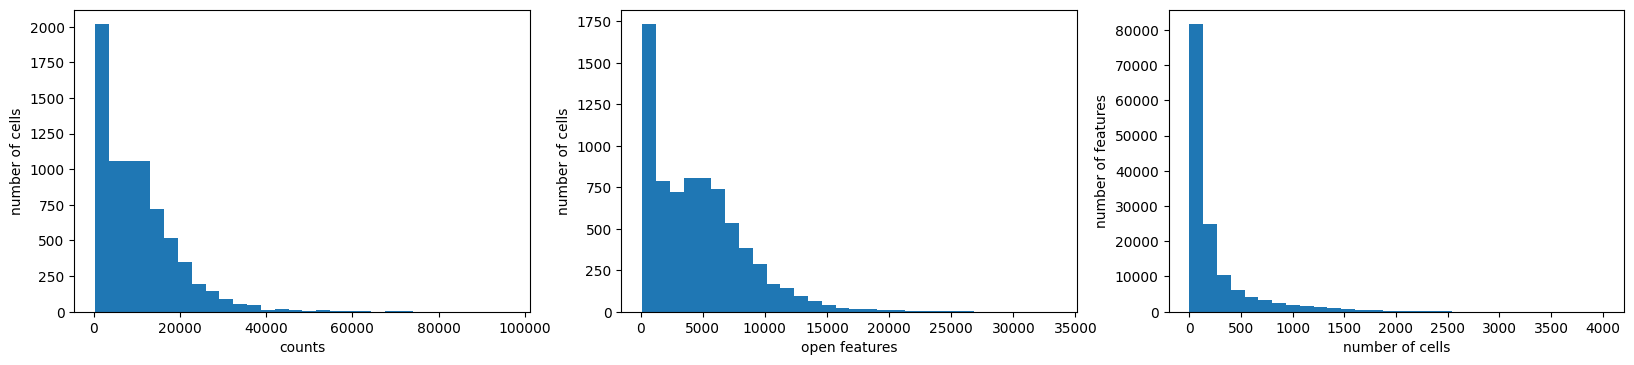

In [5]:
episcan.plot_simple_qc(myobj)

In [6]:
myobj = episcan.filter_cells_peaks(myobj, min_counts=5000, max_counts=20000, min_cells=10)

In [7]:
myobj = episcan.top_n_features(myobj, q = 0.25)

In [8]:
myobj

View of AnnData object with n_obs × n_vars = 3972 × 100639 
    obs: 0, 'nfeatures', 'ncounts'
    var: 0, 'ncells', 'ncounts'

In [9]:
myobj = episcan.tf_idf_normalization(myobj)

In [10]:
myobj = episcan.run_svd(myobj, n_components=20)

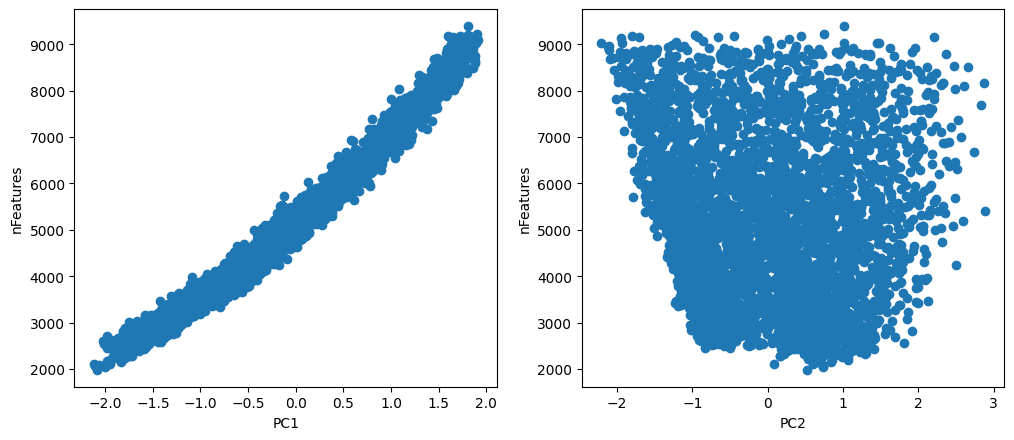

In [11]:
fig, axs = plt.subplots(1,2, figsize=(12,5), dpi=100)
axs[0].scatter(myobj.obsm['X_pca'][:,0], myobj.obs['nfeatures'])
axs[1].scatter(myobj.obsm['X_pca'][:,1], myobj.obs['nfeatures'])
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('nFeatures')
axs[1].set_xlabel('PC2')
axs[1].set_ylabel('nFeatures')
plt.show()

In [12]:
myobj.obsm['X_pca'] = np.delete(myobj.obsm['X_pca'], 0, 1)

In [13]:
myobj.obsm['X_pca'].shape

(3972, 19)

In [14]:
myobj = episcan.run_umap(myobj, n_pcs=10, n_neighbors=15, min_dist=0.4)

In [15]:
myobj = episcan.run_spectral_clustering(myobj, n_pcs=10, n_clusters=4, n_neighbors=15)

PC 1 is strongly correlated with the number of features. We shouldn't use it.

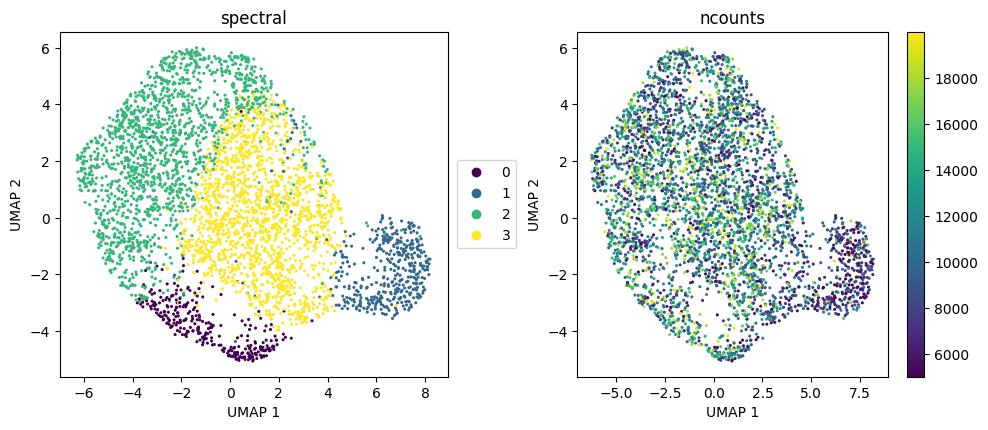

In [16]:
episcan.plot_multi_umap(myobj, colors=['spectral','ncounts'])

### Gene Activity

These chunks of code load in the hg38 coordinates of all genes (~19k) and extend the starting coordinate by 2k upstream to include promoters. 
Then, the function `gene_activity_matrix()` quantifies the accessbility of each gene. 

In [17]:
features = pd.read_csv('/project2/gca/project_organoids/metadata/hg38_gene_name_cords.txt', sep='\t', header=None)
features.columns = ['chr','start','end','gene']
features['start'] = features['start'] - 2000 # TSS + gene_body
features = features.loc[features['chr'] != 'chrM', :]
features = features.loc[features['chr'] != 'random', :]
features.drop_duplicates(subset='gene', inplace=True)

In [18]:
gene_activity = episcan.gene_activity_matrix('../scATAC-seq_Alan/RC2_Benchmark/HE021320B/outs/fragments.tsv.gz', features, myobj.obs[0].values)

 Progress: 98.38%

In [19]:
gene_activity_norm = np.log1p((gene_activity.T / gene_activity.sum(axis=1))*1e5).T

In [20]:
magic_operator = magic.MAGIC(t=5, verbose=0)
X_magic = magic_operator.fit_transform(gene_activity_norm)

  Running MAGIC with `solver='exact'` on 20330-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


In [21]:
X_magic_df = pd.DataFrame(X_magic, index = gene_activity_norm.index, columns = gene_activity_norm.columns)
X_magic_df[0] = X_magic_df.index

In [22]:
myobj.obs = myobj.obs.iloc[:,[0,1,2,3]]
myobj.obs = pd.merge(myobj.obs, X_magic_df, on=0)

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


### Identifying Cell Types from Activity Matrix

markers obtained from https://en.wikipedia.org/wiki/List_of_intestinal_epithelial_differentiation_genes

### Immature Markers

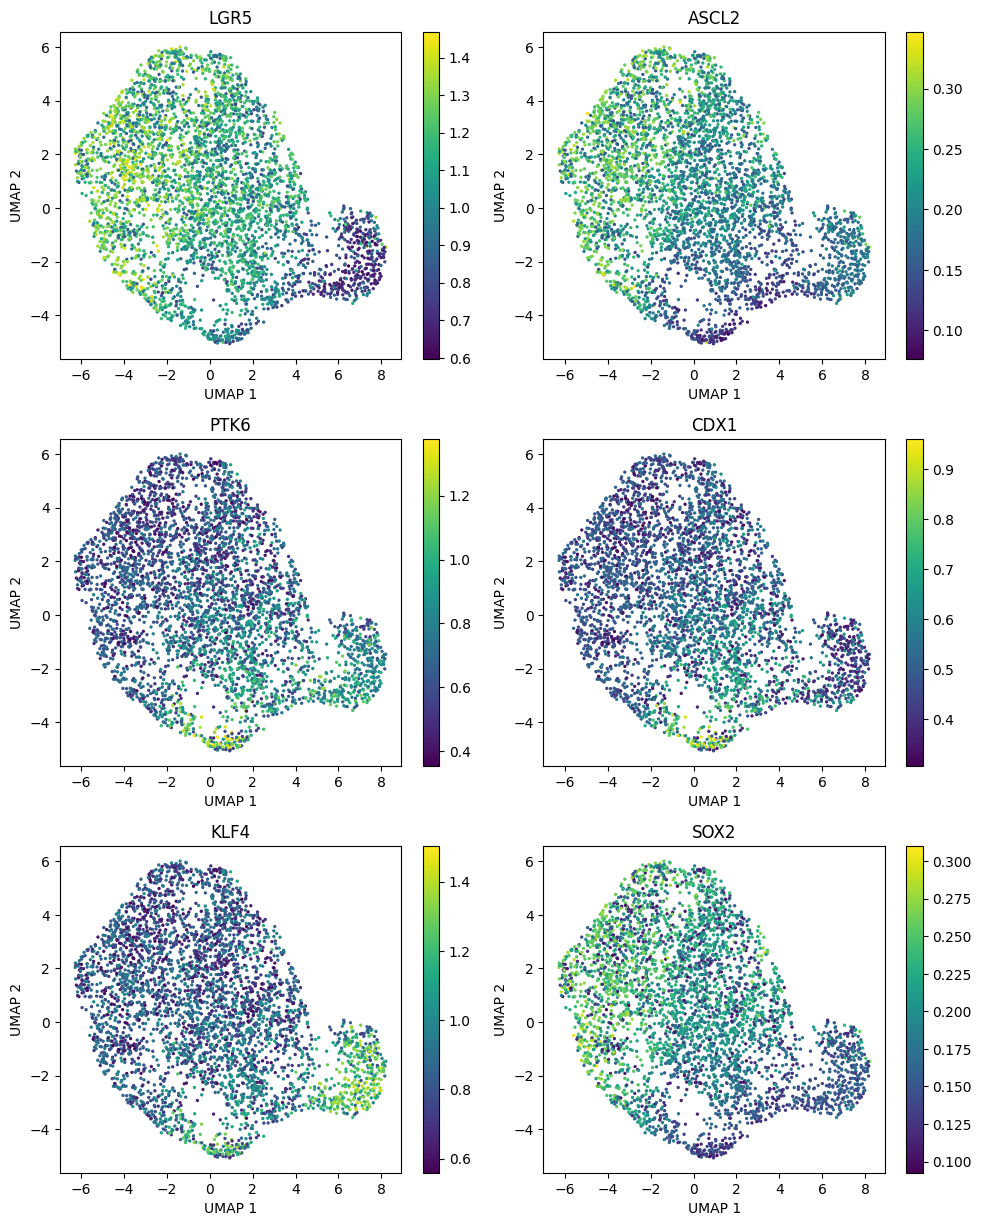

In [23]:
episcan.plot_multi_umap(myobj, colors= ['LGR5','ASCL2','PTK6','CDX1','KLF4','SOX2'], size=2)

### Mature Cell Markers

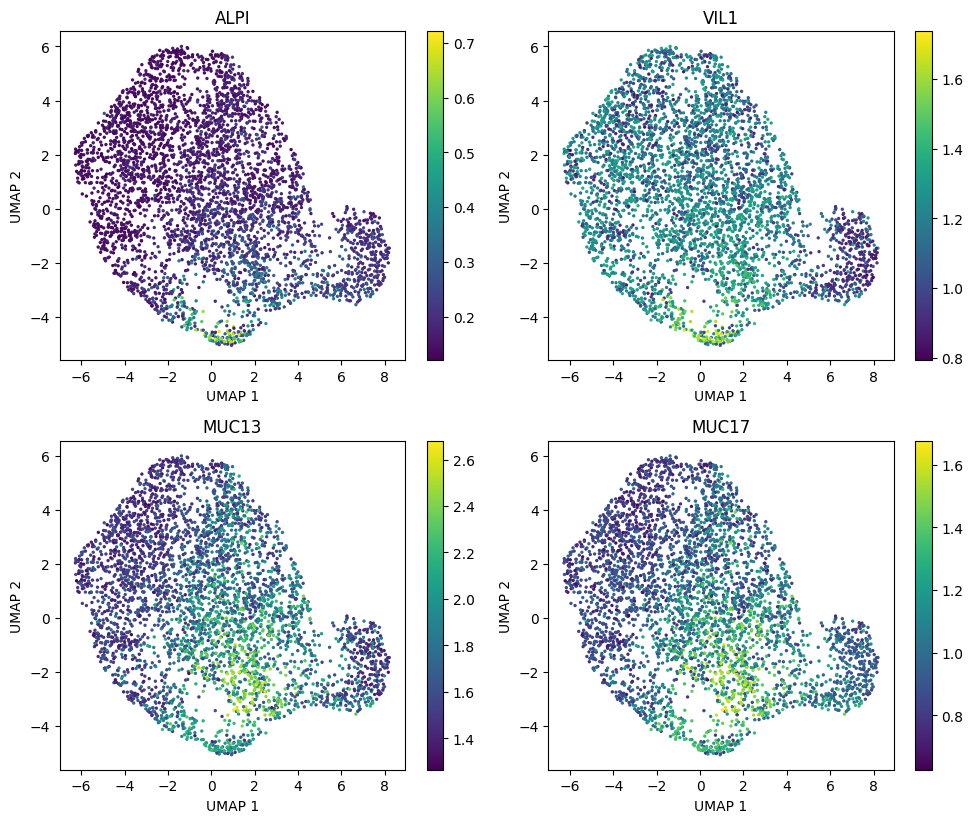

In [24]:
episcan.plot_multi_umap(myobj, colors= ['ALPI','VIL1','MUC13','MUC17'], size = 2)

In [89]:
import statsmodels.api as sm

def run_DA(AnnData, cluster, min_pct=0.1):
    
    X = AnnData.X
    nFeatures = X.shape[1]
    y = 1*(AnnData.obs['spectral'].values == cluster)
    
    results_df = pd.DataFrame(index=range(nFeatures), columns=['pct','logFC','pvalue','beta'])
    print(f"\n Now running logistic regression on cluster number {cluster}...")
    
    for i in range(nFeatures):
        
        pct = np.sum(X[y==1, i] > 0)/np.sum(y==1)
        logFC = np.log1p(np.sum(X[y==1, i])/np.sum(X[y==0, i]))
        
        if pct > min_pct:
            lr = sm.GLM(endog=y, exog=X[:,i], family=sm.families.Binomial()).fit()
            results_df.iloc[i,:] = (pct, logFC, lr.pvalues[0], lr.params[0])
            
        percent_complete = str(np.round(100*((i+1)/nFeatures), decimals=2))
        print('\r Progress: '+percent_complete+'%', end="")
        
    return results_df


def run_DA_all(AnnData, min_pct=0.1):
    
    clusters = np.unique(AnnData.obs['spectral'].values)
    result_list = []
    for clust in clusters:
        results_df = run_DA(AnnData, clust, min_pct)
        results_df = results_df.dropna()
        
        feats = AnnData.var.index.values[results_df.index.values]
        results_df['features'] = feats
        results_df['cluster'] = clust
        
        result_list.append(results_df)
    
    df_final = pd.concat(result_list, ignore_index=True)
    AnnData.uns['DA_results'] = df_final 
    return AnnData
    

In [ ]:
results = run_DA_all(myobj)


 Now running logistic regression on cluster number 0...
 Progress: 100.0%
 Now running logistic regression on cluster number 1...
 Progress: 91.77%

In [191]:
results.dropna()['pvalue']

53        6.12588e-167
71        1.06086e-165
77        5.62985e-180
120       7.68073e-159
134       2.79474e-165
              ...     
103556    2.59407e-166
103789    2.44117e-182
105067    1.53459e-182
105073    1.58646e-215
105181    7.62548e-214
Name: pvalue, Length: 1488, dtype: object